1. Make a binary classification dataset with Scikit-Learn's make_moons() function.
- For consistency, the dataset should have 1000 samples and a random_state=42.
- Turn the data into PyTorch tensors. Split the data into training and test sets using train_test_split with 80% training and 20% testing.

In [1]:
# import dataset
import torch
from torch import nn as nn
import sklearn
from sklearn.datasets import make_moons

In [10]:
import requests
from pathlib import Path

# Download helper functions from Learn Pytorch repo
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Download helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

Download helper_functions.py


In [28]:
N = 1000

X, y = make_moons(n_samples=N, random_state=42)

In [3]:
X.shape, y.shape

((1000, 2), (1000,))

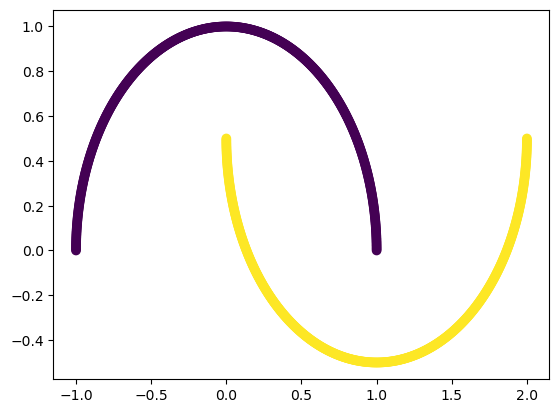

In [4]:
import matplotlib.pyplot as plt

plt.scatter(X[:,0], X[:,1], c=y)

In [29]:
from sklearn.model_selection import train_test_split
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([800, 2]),
 torch.Size([800]),
 torch.Size([200, 2]),
 torch.Size([200]))

2. Build a model by subclassing nn.Module that incorporates non-linear activation functions and is capable of fitting the data you created in 1.
Feel free to use any combination of PyTorch layers (linear and non-linear) you want.

In [53]:
from torch import nn as nn
class ImageClassificationV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_1 = nn.Linear(in_features=2,
                                  out_features=5)
        self.relu_1 = nn.ReLU()
        self.linear_2 = nn.Linear(in_features=5,
                                  out_features=10)
        self.relu_2 = nn.ReLU()
        self.linear_3 = nn.Linear(in_features=10,
                                  out_features=1)
    def forward(self, x):
        return self.linear_3(self.relu_2(self.linear_2(self.relu_1(self.linear_1(x)))))

model_0 = ImageClassificationV0()


3. Setup a binary classification compatible loss function and optimizer to use when training the model.

In [54]:
from torch.nn import BCEWithLogitsLoss
from torch.optim import SGD
loss_fn = BCEWithLogitsLoss()
optimizer = SGD(lr=0.1,
                params=model_0.parameters())

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

4. Create a training and testing loop to fit the model you created in 2 to the data you created in 1.

In [9]:
# Calculate accuracy - out of 100 examples, what percentage does our model get right?
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = correct / len(y_pred) * 100
    return acc

In [16]:
X_train

tensor([[ 1.9469,  0.1784],
        [-0.9174,  0.3979],
        [-0.0786,  0.9969],
        ...,
        [-0.7236,  0.6902],
        [ 0.9971,  0.0755],
        [ 1.9224,  0.1137]], device='cuda:0', dtype=torch.float64)

In [55]:
EPOCHS = 1200

model_0 = model_0.to(device)
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

epoch_count = []
loss_history = []
acc_history = []
test_loss_history = []
test_acc_history = []

for epoch in range(EPOCHS):
    model_0.train()
    #1. forward
    y_logits = model_0(X_train).squeeze()

    y_pred = torch.round(torch.sigmoid(y_logits))
    
    #2. Loss
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_pred, y_train)
    
    #3. Optimizer zero grad
    optimizer.zero_grad()
    
    #4. Backward
    loss.backward()
    
    #5. Optimizer step
    optimizer.step()
    
    ### Testing
    model_0.eval()
    
    with torch.inference_mode():
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)
    if epoch % 10 == 0:
        epoch_count.append(epoch)
        loss_history.append(loss)
        acc_history.append(acc)
        test_loss_history.append(test_loss)
        test_acc_history.append(test_acc)
        print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f}% | Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.71602 | Acc: 41.38% | Test loss: 0.71020 | Test acc: 44.00%
Epoch: 10 | Loss: 0.70225 | Acc: 50.00% | Test loss: 0.69920 | Test acc: 50.00%
Epoch: 20 | Loss: 0.69268 | Acc: 50.00% | Test loss: 0.69138 | Test acc: 50.00%
Epoch: 30 | Loss: 0.68420 | Acc: 50.00% | Test loss: 0.68425 | Test acc: 50.00%
Epoch: 40 | Loss: 0.67559 | Acc: 50.00% | Test loss: 0.67698 | Test acc: 50.00%
Epoch: 50 | Loss: 0.66525 | Acc: 72.75% | Test loss: 0.66811 | Test acc: 70.50%
Epoch: 60 | Loss: 0.65187 | Acc: 76.75% | Test loss: 0.65642 | Test acc: 72.50%
Epoch: 70 | Loss: 0.63351 | Acc: 79.50% | Test loss: 0.64006 | Test acc: 74.50%
Epoch: 80 | Loss: 0.60929 | Acc: 81.38% | Test loss: 0.61813 | Test acc: 77.00%
Epoch: 90 | Loss: 0.57838 | Acc: 81.38% | Test loss: 0.58978 | Test acc: 77.50%
Epoch: 100 | Loss: 0.54013 | Acc: 81.25% | Test loss: 0.55394 | Test acc: 79.50%
Epoch: 110 | Loss: 0.49538 | Acc: 81.00% | Test loss: 0.51200 | Test acc: 80.50%
Epoch: 120 | Loss: 0.44948 | Acc: 81.25

In [ ]:
loss_history

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


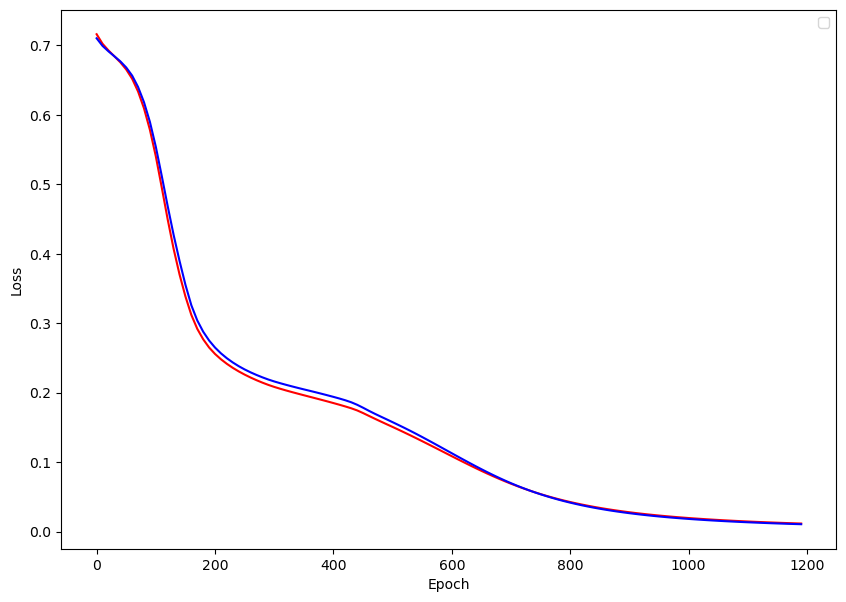

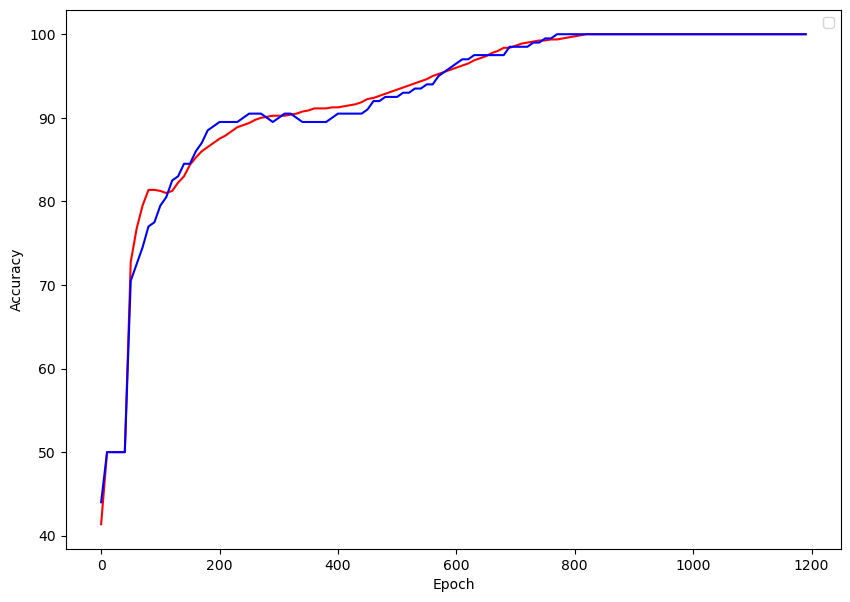

In [64]:
plt.figure(figsize=(10,7))
plt.plot(epoch_count, torch.tensor(loss_history, device = 'cpu'), c='r')
plt.plot(epoch_count, torch.tensor(test_loss_history, device='cpu'), c='b')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.figure(figsize=(10,7))
plt.plot(epoch_count, torch.tensor(acc_history, device = 'cpu'), c='r')
plt.plot(epoch_count, torch.tensor(test_acc_history, device='cpu'), c='b')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

5. Make predictions with your trained model and plot them using the plot_decision_boundary() function created in this notebook.

In [72]:
model_0

ImageClassificationV0(
  (linear_1): Linear(in_features=2, out_features=5, bias=True)
  (relu_1): ReLU()
  (linear_2): Linear(in_features=5, out_features=10, bias=True)
  (relu_2): ReLU()
  (linear_3): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
model_0.to(device)
with torch.inference_mode():
    y_test_logits = model_0(X_test).squeeze()
    y_preds = torch.round(torch.sigmoid(y_test_logits))


torch.Size([200])


IndexError: too many indices for tensor of dimension 1

In [ ]:
def tanh(x):
    return (torch.exp(x) - torch.exp(-x))/(torch.exp(x) + torch.exp(-x))